# I. FT-LLM Final Results. Error Analysis. DF read from checkpoint 

Here we read the test results from CSV file.

IN this DataFrame we collect test 1000 samples with inference results done for several FT (fine-tuned) models and different runs 

```bash
notebooks$ ls -ltr final_ft_results_test_set_1000_with_validated_signals_2024-01-25T11_52_50.csv
-rw-r--r--@ 1 d071932  staff  13014098 Jan 25 11:52 final_ft_results_test_set_1000_with_validated_signals_2024-01-25T11_52_50.csv
```

In [12]:
import pandas as pd
pd.set_option('display.max_colwidth', None)


filename_final_res_read="final_ft_results_test_set_1000_with_validated_signals_2024-01-25T11_52_50.csv" # 11 Jan 2024 11 epoch code-llama 490 
filename_final_res_read="final_ft_results_test_set_1000_with_validated_signals_2024-02-02T09_39_29.csv" # 2 Feb 2024 11 epoch code-llama 491 perfect


# Read  DF with LLM-generated s description from file system 
dfp = pd.read_csv(filename_final_res_read)

## Sanity 
dfp.columns

Index(['Unnamed: 0', 'filename', 'split', 'name', 'query', 'llm_name',
       'description_llm', 'llm_mistral_full_output_base',
       'llm_mistral_query_base', 'workspace_name', 'APIvalidated_mistral_base',
       'validationDataResponse_mistral_base',
       'validationDataLength_mistral_base', 'APIvalidated_gt',
       'validationDataResponse_gt', 'validationDataLength_gt',
       'llm_mistral_full_output_3_epoch', 'llm_mistral_query_3_epoch',
       'APIvalidated_mistral_3_epoch',
       'validationDataResponse_mistral_3_epoch',
       'validationDataLength_mistral_3_epoch',
       'llm_mistral_full_output_10_epoch', 'llm_mistral_query_10_epoch',
       'APIvalidated_mistral_10_epoch',
       'validationDataResponse_mistral_10_epoch',
       'validationDataLength_mistral_10_epoch',
       'llm_codellama_full_output_10_epoch', 'llm_codellama_query_10_epoch',
       'APIvalidated_codellama_10_epoch',
       'validationDataResponse_codellama_10_epoch',
       'validationDataLength_co

In [8]:
#dfp=df_for_api
#cols=['name', 'query', 'llm_mistral_query_3_epoch', 'description_llm','mistral_correct','validationDataResponse_3_epoch','validationDataResponse_3_epoch']
#dfp[ (dfp["mistral_correct"] == False) &  (dfp['APIvalidated_3_epoch'] == "ok")][cols]

cols=['name', 'query', 
      'llm_codellama_query_10_epoch', 
      'description_llm',
      'codellama_correct_10_epoch',
      'APIvalidated_codellama_11_epoch_lr05',
      'validationDataResponse_codellama_11_epoch_lr05']

dfp [dfp['APIvalidated_codellama_10_epoch'] != "ok"][cols] [['query','description_llm']].tail(n=5) #.to_excel("samples.xlsx",engine='xlsxwriter')

,query,description_llm
992,"SELECT COUNT (""case_id"") AS ""Cases""\nFROM ""defaultview-124""\nWHERE\n(NOW() - (SELECT LAST(END_TIME) WHERE EVENT_NAME = 'Release PO')) > DURATION '45DAYS'","From the table 'defaultview-124', count the number of unique values in the 'case_id' column and alias it as 'Cases'. Only include rows where the current date/time minus 45 days is greater than the latest 'END_TIME' value where 'EVENT_NAME' equals 'Release PO'."
993,"\nSELECT\nCOUNT(case_id) FILTER (WHERE\n\t(SELECT BOOL_OR (occurrence > 1)\n\t\tFROM(SELECT OCCURRENCE(event_name) AS occurrence) AS sub\n)\n)/COUNT(case_id)*100\nFROM ""defaultview-124""\n","First, from the table 'defaultview-124', count the total number of case_id values. Then, check if there are any event_name values that occur more than once, by using a subquery to count the occurrence of each event_name and seeing if any are greater than 1. If there are any event_names occurring more than once, return true. Use BOOL_OR to check if any of these subquery checks returned true. Finally, filter the initial case_id count to only those rows where the event_name occurrence check returned true. Divide this filtered count by the total case_id count and multiply by 100 to get the percentage of cases where an event occurred more than once."
994,"SELECT count(case_id) Filter( \nWhere ""Scheduled Release Date"" - ""Actual Release Date"" > DURATION '0seconds' AND ""Event Created By User Type"" NOT in ('Dialog') AND event_name = 'Released' )\n/\ncount(case_id) Filter(Where ""Scheduled Release Date"" - ""Actual Release Date"" > DURATION '0seconds' AND event_name = 'Released') *100\nFROM FLATTEN(""defaultview-183"")\nWHERE ""Planned Order Number"" IS NOT NULL\n","First, from the 'defaultview-183' table where 'Planned Order Number' column is not null, filter the rows where the difference between 'Scheduled Release Date' and 'Actual Release Date' columns is greater than 0 seconds and 'Event Created By User Type' column value is not 'Dialog' and 'event_name' column value is 'Released'. Count the 'case_id' values in this filtered resultset. \n\nSecond, from the 'defaultview-183' table where 'Planned Order Number' column is not null, filter the rows where the difference between 'Scheduled Release Date' and 'Actual Release Date' columns is greater than 0 seconds and 'event_name' column value is 'Released'. Count the 'case_id' values in this filtered resultset.\n\nFinally, divide the first count by the second count, and multiply by 100 to get the percentage."
998,"SELECT COUNT (DISTINCT ARUniqueKey) \nFILTER (WHERE EVENT_NAME = 'Create Accounts Receivable' \nAND ClearingJournalEntry IS NULL\nAND (NOW()-NetDueDate)> DURATION '15day')\nas ""#Receivables"" , \n ""Project_Manager"" as ""Project Manager""\nFROM FLATTEN(""defaultview-197"")\nGROUP BY 2\nORDER By 1 DESC\nLIMIT 10","From the 'defaultview-197' table, select the count of distinct ARUniqueKey values where EVENT_NAME is 'Create Accounts Receivable' and ClearingJournalEntry is null and the difference between NOW() and NetDueDate is greater than 15 days. Alias this count as '#Receivables'. Also select the 'Project_Manager' column and alias it as 'Project Manager'. Group the results by 'Project Manager' and order them descending by '#Receivables'. Limit the results to the top 10 rows."
999,"SELECT COUNT (""event_name"") FILTER (WHERE BEHAVIOUR (EVENT_NAME LIKE \n 'Change Invoice%' OR event_name LIKE 'Create Invoice Item Cancellation%' OR event_name LIKE 'Update Invoice%') AS created_with_dialog MATCHES (created_with_dialog)),""SalesDocCustomerCompany"" \nFROM FLATTEN(""defaultview-290"")\nGROUP BY 2\norder by 1 desc\nLimit 10","The query is selecting the count of event_name column from the defaultview-290 table where the event_name value matches the pattern 'Change Invoice%', 'Create Invoice Item Cancellation%' or 'Update Invoice%'. It groups the results by the SalesDocCustomerCompany column and orders the counts in descending order. Only the top

## Plotting error analysis

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')  

def err_detect(text, err_variants=['ok','<EOF>','ColumnNotFound:',
                                   "DisallowedNestedExpression",
                                   "NoSuchFunction","MatchesOnNonNestedDataError","MissingDataSourceError:","InvalidArguments", "Syntax error"]):
    #text_org=text
    text = [ err  for err in err_variants if err in text ]
    if len(text) > 0:
        text=text[0]
    else:
        #print(text_org)
        text="other"
        
    return text

def plot_pairweise(dfp,c1,c2,d1,d2):    

    #c1='APIvalidated_mistral_3_epoch'
    #c2='APIvalidated_mistral_10_epoch'
    #d1="mistral_correct_3_epoch"
    #d2="mistral_correct_10_epoch"   

    y= dfp[c1].apply(lambda x: err_detect(x)) 
    y1= dfp[c2].apply(lambda x: err_detect(x))  

    plt.rcParams["figure.figsize"] = (14,6) 

    ax =  y.value_counts().reset_index().plot.barh( y="count", x=c1, edgecolor='white', linewidth=1, alpha=0.3,  color='lime', 
                                                   label=c1)
    y1.value_counts().reset_index().plot.barh(x=c2, y="count",  edgecolor='red', linewidth=1, alpha=0.3,  color='blue', ax=ax, 
                                              label=c2)
    t1=y.value_counts()['ok']
    t2=y1.value_counts()['ok']  

    val1= dfp[d1].value_counts().values[1]
    val2= dfp[d2].value_counts().values[1]   

    plt.legend([f'{c1} : 100% Valid {val1} out of {t1}',f'{c2} : 100% Valid {val2} out of {t2}' ])
    plt.title(f'Err Count distribution')
    y.value_counts() , y1.value_counts()
        

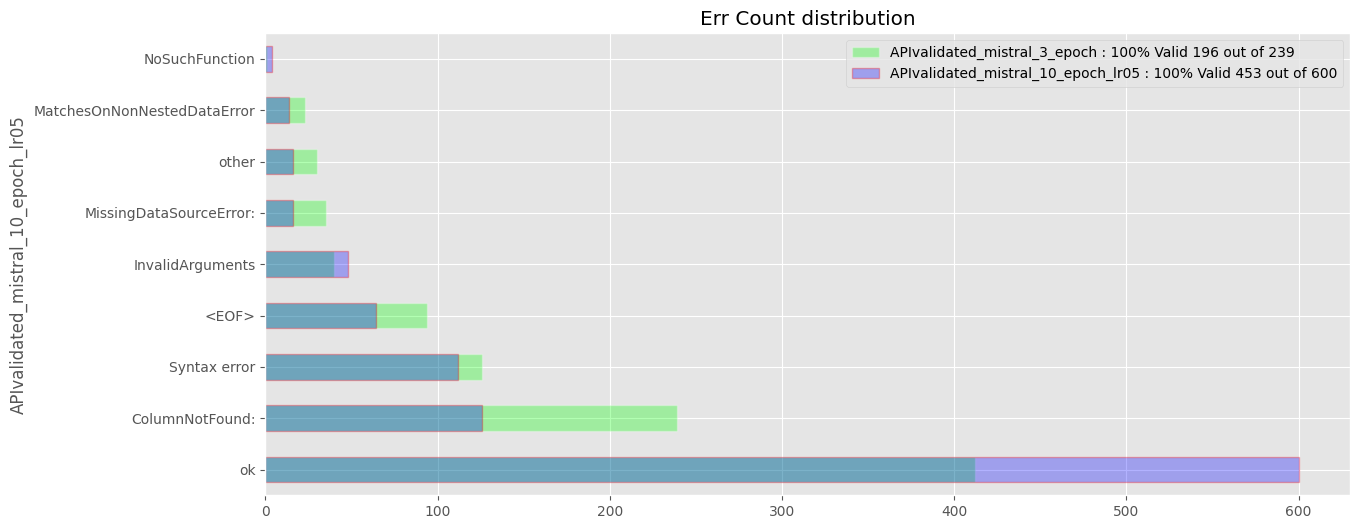

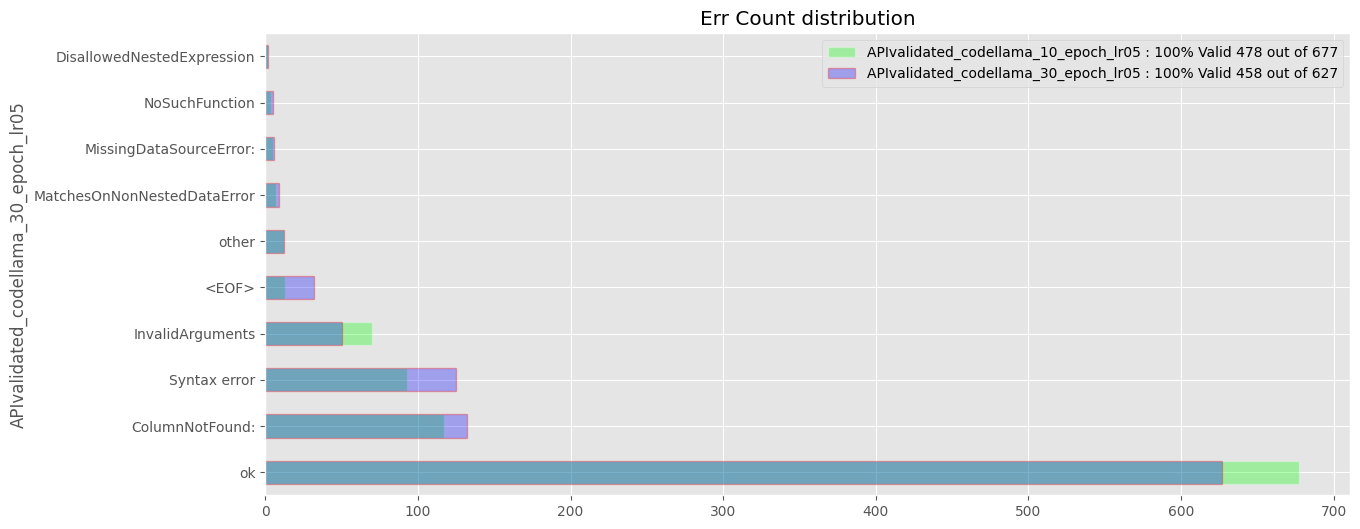

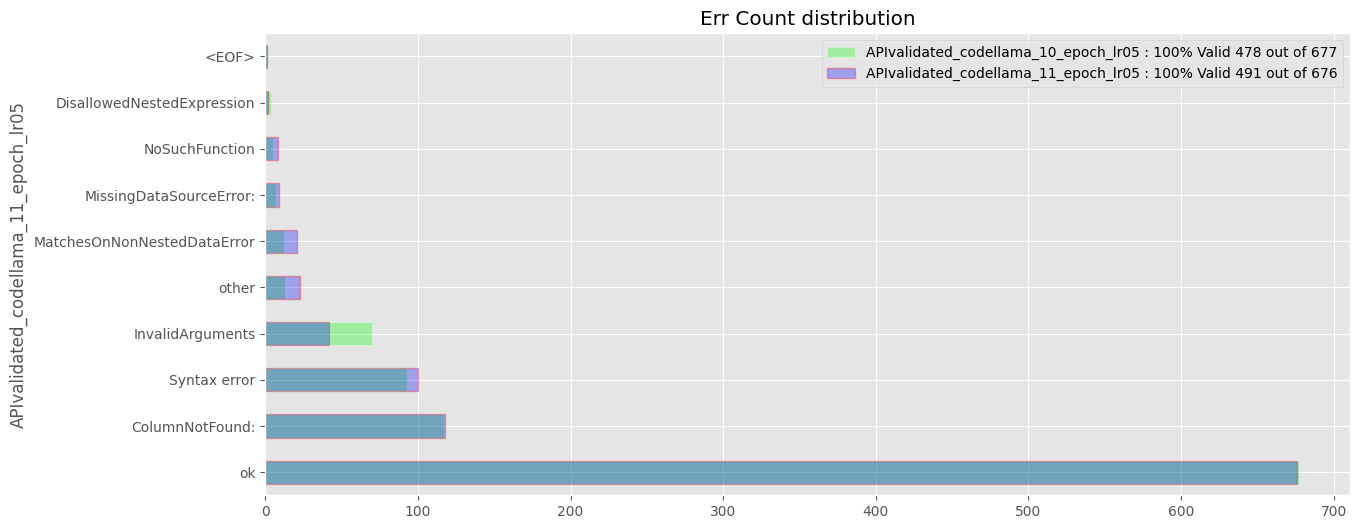

In [13]:
c1='APIvalidated_mistral_3_epoch'
c2='APIvalidated_mistral_10_epoch'
d1="mistral_correct_3_epoch"
d2="mistral_correct_10_epoch"


c1='APIvalidated_mistral_10_epoch'
c2='APIvalidated_codellama_10_epoch'
d1="mistral_correct_10_epoch"
d2="codellama_correct_10_epoch"

c1='APIvalidated_mistral_10_epoch_lr05'
c2='APIvalidated_codellama_10_epoch_lr05'
d1="mistral_correct_10_epoch_lr05"
d2="codellama_correct_10_epoch_lr05"



c1='APIvalidated_mistral_3_epoch'
c2='APIvalidated_mistral_10_epoch_lr05'
d1="mistral_correct_3_epoch"
d2="mistral_correct_10_epoch_lr05"
plot_pairweise(dfp,c1,c2,d1,d2)

#c1='APIvalidated_mistral_10_epoch'
#c2='APIvalidated_mistral_10_epoch_lr05'
#d1="mistral_correct_10_epoch"
#d2="mistral_correct_10_epoch_lr05"

c1='APIvalidated_codellama_10_epoch_lr05'
c2='APIvalidated_codellama_30_epoch_lr05'
d1="codellama_correct_10_epoch_lr05"
d2="codellama_correct_30_epoch_lr05"
plot_pairweise(dfp,c1,c2,d1,d2)


c1='APIvalidated_codellama_10_epoch_lr05'
c2='APIvalidated_codellama_11_epoch_lr05'
d1="codellama_correct_10_epoch_lr05"
d2="codellama_correct_11_epoch_lr05"
plot_pairweise(dfp,c1,c2,d1,d2)



In [14]:

c1='APIvalidated_mistral_10_epoch'
c2='APIvalidated_mistral_10_epoch_lr05'
c1='APIvalidated_codellama_10_epoch'
c2='APIvalidated_codellama_10_epoch_lr05'
c1='APIvalidated_codellama_10_epoch_lr05'
c2='APIvalidated_codellama_11_epoch_lr05'
a = dfp[c1].apply(lambda x: err_detect(x)) .value_counts().reset_index().rename(columns={c1:"stat"}) 
b = dfp[c2].apply(lambda x: err_detect(x)) .value_counts().reset_index().rename(columns={c2:"stat"}) 

dfplt = pd.merge(a,b , on='stat')
dfplt


,stat,count_x,count_y
0,ok,677,676
1,ColumnNotFound:,117,118
2,Syntax error,93,100
3,InvalidArguments,70,42
4,other,13,23
5,MatchesOnNonNestedDataError,12,21
6,MissingDataSourceError:,7,9
7,NoSuchFunction,5,8
8,<EOF>,4,1
9,DisallowedNestedExpression,2,2


In [11]:
dfp_error=dfp.copy()
dfp_error.columns

Index(['Unnamed: 0', 'filename', 'split', 'name', 'query', 'llm_name',
       'description_llm', 'llm_mistral_full_output_base',
       'llm_mistral_query_base', 'workspace_name', 'APIvalidated_mistral_base',
       'validationDataResponse_mistral_base',
       'validationDataLength_mistral_base', 'APIvalidated_gt',
       'validationDataResponse_gt', 'validationDataLength_gt',
       'llm_mistral_full_output_3_epoch', 'llm_mistral_query_3_epoch',
       'APIvalidated_mistral_3_epoch',
       'validationDataResponse_mistral_3_epoch',
       'validationDataLength_mistral_3_epoch',
       'llm_mistral_full_output_10_epoch', 'llm_mistral_query_10_epoch',
       'APIvalidated_mistral_10_epoch',
       'validationDataResponse_mistral_10_epoch',
       'validationDataLength_mistral_10_epoch',
       'llm_codellama_full_output_10_epoch', 'llm_codellama_query_10_epoch',
       'APIvalidated_codellama_10_epoch',
       'validationDataResponse_codellama_10_epoch',
       'validationDataLength_co

In [15]:

c1='APIvalidated_codellama_11_epoch_lr05'
dfp_error["errors_"+c1] = dfp[c1].apply(lambda x: err_detect(x))

err="Syntax error"
err="ColumnNotFound:"
#err="InvalidArguments"
dfp_error[dfp_error["errors_"+c1] == err]['llm_name'].value_counts()

dfp_error[dfp_error["errors_"+c1] == err]['query'].value_counts()

dfp_error[dfp_error["errors_"+c1] == err]['llm_codellama_query_10_epoch_lr05'].value_counts()

cls=['llm_name','query','llm_codellama_query_10_epoch_lr05',"errors_"+c1, 'description_llm']
dfp_error[ dfp_error["errors_"+c1] == err ]

txt='SELECT\n    "Project",\n    AVG(C) AS "Avg Cycle Time"\nFROM (\n\tSELECT \n'
txt='SELECT\n    "Project",\n    AVG(C) AS "Avg Cycle Time"\nFROM'
dd = dfp_error[dfp_error["errors_"+c1] == err]['query'].value_counts()
print(list( zip(dd.index, dd.values))[0])
txt = """{}""".format(list( zip(dd.index, dd.values))[0])
#txt='SELECT\n    "Project",\n    AVG(C) AS"'
txt= dfp_error['query'][0]
dfp_error[ dfp_error['query'].astype(str) == txt]  #.contains(txt).value_counts()


#dfp_error[ dfp_error["errors_"+c1] == err AND dfp_error['query'].str.contains(txt) == True ][cls]



NameError: name 'dfp_error' is not defined

In [13]:
df1 = dfp_error[dfp_error["errors_"+c1] == err] #['query']#.value_counts()


df1
df1.groupby('query').filter(lambda x: len(x) == 5)  #.query

,Unnamed: 0,filename,split,name,query,llm_name,description_llm,llm_mistral_full_output_base,llm_mistral_query_base,workspace_name,...,validationDataResponse_codellama_11_epoch_lr05,validationDataLength_codellama_11_epoch_lr05,mistral_correct_3_epoch,mistral_correct_10_epoch,codellama_correct_10_epoch,codellama_correct_10_epoch_lr05,mistral_correct_10_epoch_lr05,codellama_correct_30_epoch_lr05,codellama_correct_11_epoch_lr05,errors_APIvalidated_codellama_11_epoch_lr05
84,84,6ad1f0922e,test,Ø SFC Initial Quantity,"SELECT AVG(""SFC Initial Quantity"") FROM ""defau...",signal_description_llama2-70b-chat-hf,Calculate the average value of the 'SFC Initia...,"\n [INST]\n You are SIGNAL assistant, a par...","""SELECT AVG(\""SFC Initial Quantity\"") FROM \""...",Solutions Demo Workspace,...,Error 422 Client Error: Unprocessable Entity f...,0,True,True,True,True,True,True,False,ColumnNotFound:
174,174,44cae3c190,test,Avg. Cycle Time per Project (20 longest running),"SELECT\n ""Project"",\n AVG(C) AS ""Avg Cyc...",signal_description_llama2-70b-chat-hf,Retrieve the average cycle time for each proje...,"\n [INST]\n You are SIGNAL assistant, a par...","\n [INST]\n You are SIGNAL assistant, a par...",Solutions Demo Workspace,...,Error 422 Client Error: Unprocessable Entity f...,0,False,False,False,False,False,False,False,ColumnNotFound:
284,284,6ad1f0922e,test,Ø SFC Initial Quantity,"SELECT AVG(""SFC Initial Quantity"") FROM ""defau...",signal_description_gpt-35-turbo,Calculate the average value of the 'SFC Initia...,"\n [INST]\n You are SIGNAL assistant, a par...","""SELECT AVG(\""SFC Initial Quantity\"") FROM \""...",Solutions Demo Workspace,...,Error 422 Client Error: Unprocessable Entity f...,0,True,True,True,True,False,True,False,ColumnNotFound:
374,374,44cae3c190,test,Avg. Cycle Time per Project (20 longest running),"SELECT\n ""Project"",\n AVG(C) AS ""Avg Cyc...",signal_description_gpt-35-turbo,Calculate the average cycle time for each proj...,"\n [INST]\n You are SIGNAL assistant, a par...","\n [INST]\n You are SIGNAL assistant, a par...",Solutions Demo Workspace,...,Error 422 Client Error: Unprocessable Entity f...,0,False,False,False,False,False,False,False,ColumnNotFound:
484,484,6ad1f0922e,test,Ø SFC Initial Quantity,"SELECT AVG(""SFC Initial Quantity"") FROM ""defau...",signal_description_gpt-4,The given SIGNAL query is calculating the aver...,"\n [INST]\n You are SIGNAL assistant, a par...","""SELECT AVG(\""SFC Initial Quantity\"") FROM de...",Solutions Demo Workspace,...,Error 422 Client Error: Unprocessable Entity f...,0,True,True,True,False,True,False,False,ColumnNotFound:
574,574,44cae3c190,test,Avg. Cycle Time per Project (20 longest running),"SELECT\n ""Project"",\n AVG(C) AS ""Avg Cyc...",signal_description_gpt-4,The SIGNAL query is designed to select the 'Pr...,"\n [INST]\n You are SIGNAL assistant, a par...",NaN,Solutions Demo Workspace,...,Error 422 Client Error: Unprocessable Entity f...,0,False,False,False,False,False,False,False,ColumnNotFound:
684,684,6ad1f0922e,test,Ø SFC Initial Quantity,"SELECT AVG(""SFC Initial Quantity"") FROM ""defau...",signal_description_anthropic-claude-v1,Calculate the average value of the column name...,"\n [INST]\n You are SIGNAL assistant, a par...","""SELECT AVG(\""SFC Initial Quantity\"") FROM \""...",Solutions Demo Workspace,...,Error 422 Client Error: Unprocessable Entity f...,0,True,True,True,False,True,False,False,ColumnNotFound:
774,774,44cae3c190,test,Avg. Cycle Time per Project (20 longest running),"SELECT\n ""Project"",\n AVG(C) AS ""Avg Cyc...",signal_description_anthropic-claude-v1,Select the 'Project' column and calculate the ...,"\n [INST]\n You are SIGNAL assistant, a par...","""SELECT AVG(C) AS avg_cycle_time, COUNT(\*) A...",Solutions Demo Workspace,...,Error 422 Client Error: Unprocessable Entity f...,0,False,False,False,False,False,False,False,ColumnNotFound:
884,884,6ad1f0922e,test,Ø SFC Initial Quantity,"SELECT AVG(""SFC Initial Quantity"") FROM ""defau...",signal

In [14]:
#err="Syntax error"
#err="InvalidArguments"
#err="ColumnNotFound:"
c1='APIvalidated_codellama_11_epoch_lr05'
dfp_error["errors_"+c1] = dfp[c1].apply(lambda x: err_detect(x))

err="Syntax error"
err="ColumnNotFound:"
#err="InvalidArguments"

dfp_error[dfp_error["errors_"+c1] == err]['llm_name'].value_counts()

#dfp_error[dfp_error["errors_"+c1] == err]['query'].value_counts()

#dfp_error[dfp_error["errors_"+c1] == err]['llm_codellama_query_11_epoch_lr05'].value_counts()

dd = dfp_error[dfp_error["errors_"+c1] == err]['query'].value_counts() # .head(n=10)
list( zip(dd.index, dd.values))[0][0]
    

'SELECT\n    "Project",\n    AVG(C) AS "Avg Cycle Time"\nFROM (\n\tSELECT \n        case_id,\n        "Project_Description"  as "Project",\n   \t(SELECT LAST(end_time) FILTER (WHERE event_name = \'Close Project\') \n    \t      - FIRST(end_time) FILTER (WHERE event_name = \'Start Project\')) AS C\n\tFROM "defaultview-197"\n) AS sub\nORDER BY 2 DESC\nLIMIT 20\n'